# Load data from Kaggle

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
%%time
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download jessicali9530/celeba-dataset

 98% 1.31G/1.33G [00:07<00:00, 224MB/s]
100% 1.33G/1.33G [00:07<00:00, 180MB/s]
CPU times: user 69 ms, sys: 18.9 ms, total: 88 ms
Wall time: 8.86 s


In [3]:
!unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

# Imports

In [ ]:
!pip install face_recognition
!pip install opencv-python

In [ ]:
import pandas as pd
import numpy as np
import cmath
from matplotlib import pyplot as plt
import cv2
import face_recognition
import os
import random

# Prepare dataset

## Load data

In [ ]:
def load_images_from_folder(folder, a=None,b=None, files=None):
    images = []
    filenames = []

    if files is not None: filenames = files
    else: filenames = os.listdir(folder)[a:b]

    for filename in filenames:
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if img is not None:
            images.append(img)
        
    return np.array(images)

In [ ]:
labels = pd.read_csv(
    "/content/identity_CelebA.txt",
    sep=" ",
    names=["image", "identity"]
)
train_data_labels = pd.read_csv(
    'https://raw.githubusercontent.com/marianpetruk/face-recognition-linear-algebra/master/sample_1k.txt?token=AJIWF7EJDRZPGY277AWFB33AGPSBQ',
    usecols=[1,2],
    names=["image", "identity"]
)

test_data_labels_all = labels[182638:]
test_data_labels = test_data_labels_all[test_data_labels_all['identity'].isin(train_data_labels['identity'])]
test_data_labels = test_data_labels.sample(200, random_state=10)

In [ ]:
print(f'Train data shape = {train_data_labels.shape}; Test data shape = {test_data_labels.shape}')

Train data shape = (1000, 2); Test data shape = (200, 2)


In [ ]:
labels.head()

,image,identity
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [ ]:
image_folder = "/content/img_align_celeba/img_align_celeba/"
train_images = load_images_from_folder(image_folder, files=train_data_labels['image'])
test_images = load_images_from_folder(image_folder, files=test_data_labels['image'])

## Detect landmarks

In [ ]:
train_landmarks = [face_recognition.face_landmarks(image) for image in train_images]
test_landmarks = [face_recognition.face_landmarks(image) for image in test_images]

In [ ]:
train_data_labels["landmarks"] = train_landmarks
test_data_labels["landmarks"] = test_landmarks

FIlter faces with no landmarks detected due to bad angle of view or some other things.

In [ ]:
train_data_labels = train_data_labels[train_data_labels['landmarks'].map(lambda landmarks: len(landmarks) > 0)]
test_data_labels = test_data_labels[test_data_labels['landmarks'].map(lambda landmarks: len(landmarks) > 0)]

In [ ]:
print(f'Train data shape = {train_data_labels.shape}; Test data shape = {test_data_labels.shape}')

Train data shape = (979, 3); Test data shape = (197, 3)


In [492]:
test_data_labels.head()

,image,identity,landmarks,landmarks_complex,predicted_identity_1,predicted_identity_5,predicted_identity_15,predicted_identity_24,predicted_identity_34,predicted_identity_44,predicted_identity_54,predicted_identity_64,predicted_identity_73,predicted_identity_83,predicted_identity_93,predicted_identity_103,predicted_identity_113,predicted_identity_122,predicted_identity_132,predicted_identity_142,predicted_identity_152,predicted_identity_181,predicted_identity_210,predicted_identity_240,predicted_identity_269,predicted_identity_299,predicted_identity_328,predicted_identity_357,predicted_identity_387
199536,199537.jpg,8912,"[(41, 99), (41, 112), (43, 125), (46, 137), (5...","[[(41+99j)], [(41+112j)], [(43+125j)], [(46+13...",[10163],"[3490, 10163, 3684, 7178, 1695]","[3490, 561, 10163, 3684, 7550, 7178, 693, 2866...","[3490, 561, 10163, 3684, 4433, 7550, 7178, 521...","[3490, 6794, 561, 10163, 3684, 1550, 4061, 443...","[3490, 6794, 561, 10163, 1198, 3684, 1550, 406...","[3490, 9826, 10015, 6794, 561, 10163, 1198, 36...","[3490, 9826, 7029, 1358, 10015, 6794, 3542, 56...","[3490, 9826, 9117, 7029, 1358, 1230, 10015, 67...","[3490, 9826, 9117, 7029, 1358, 1230, 10015, 67...","[3490, 9826, 9117, 7029, 1358, 1230, 10015, 67...","[3490, 3236, 9826, 9117, 7029, 7483, 1358, 123...","[3490, 3236, 9826, 9117, 7029, 7483, 1358, 123...","[3490, 3236, 9826, 9117, 7029, 7483, 1358, 123...","[3490, 3236, 9826, 2762, 9117, 7029, 7483, 135...","[3490, 3236, 9826, 2762, 9117, 7029, 7483, 135...","[3490, 3236, 9826, 2762, 9117, 7029, 7483, 135...","[3490, 3236, 879, 8609, 9826, 2762, 9117, 5734...","[3490, 3236, 879, 8609, 9826, 2762, 9117, 5734...","[3490, 3236, 879, 8609, 9826, 2762, 9117, 5734...","[3490, 3236, 879, 8609, 9826, 2762, 9117, 5734...","[3490, 3236, 879, 8609, 9826, 2762, 9117, 5734...","[3490, 3236, 879, 8609, 9826, 2762, 9117, 5734...","[3490, 3236, 879, 8609, 9826, 2762, 9117, 5734...","[3490, 3236, 879, 8609, 9826, 2762, 9117, 5734..."
199178,199179.jpg,5614,"[(46, 114), (46, 126), (47, 138), (49, 149), (...","[[(46+114j)], [(46+126j)], [(47+138j)], [(49+1...",[5614],"[3164, 5614, 7046, 1533, 7276]","[1252, 9714, 8144, 10153, 3164, 5614, 9226, 79...","[1252, 9714, 8144, 10153, 3164, 5614, 9226, 79...","[1252, 4341, 9714, 8144, 10153, 3164, 7204, 56...","[1252, 4341, 9714, 7102, 8144, 1700, 10153, 50...","[1252, 879, 4341, 9714, 918, 7102, 8144, 1700,...","[1252, 879, 4341, 9714, 918, 7102, 8144, 2429,...","[1252, 879, 4341, 9714, 918, 7102, 8144, 2429,...","[1252, 879, 4341, 9714, 8275, 4962, 918, 7102,...","[1252, 879, 4341, 6826, 9714, 8275, 4962, 918,...","[1252, 879, 1358, 3358, 4341, 6826, 1121, 7367...","[1252, 879, 2762, 1358, 3358, 4341, 6826, 1121...","[1252, 879, 2762, 1358, 3358, 4341, 6826, 1121...","[1252, 879, 2762, 1358, 3358, 4341, 6468, 6826...","[1252, 879, 2762, 1358, 3358, 4341, 6468, 6826...","[1252, 879, 2762, 1358, 3358, 4341, 10015, 800...","[1252, 879, 2762, 1358, 3358, 4341, 10015, 330...","[1252, 879, 2762, 599, 1358, 3358, 1230, 4341,...","[1252, 879, 2762, 599, 2630, 1358, 3358, 1230,...","[1252, 879, 2762, 599, 2630, 1358, 3358, 1230,...","[1252, 879, 2762, 599, 2630, 1358, 3358, 1230,...","[1252, 879, 2762, 599, 2630, 1358, 3358, 2495,...","[1252, 879, 2762, 8614, 599, 8491, 2630, 1358,...","[1252, 879, 2762, 8614, 599, 8491, 2630, 350, ..."
185847,185848.jpg,6956,"[(36, 116), (36, 129), (38, 142), (42, 155), (...","[[(36+116j)], [(36+129j)], [(38+142j)], [(42+1...",[7220],"[6237, 2608, 586, 7220, 3695]","[126, 9719, 9779, 1196, 6176, 4628, 6106, 6237...","[126, 9719, 7526, 9779, 1196, 7364, 6176, 4628...","[5734, 9775, 126, 9719, 8027, 7526, 7007, 9779...","[5734, 9884, 9775, 126, 9719, 8027, 7526, 7007...","[5734, 4838, 7029, 7483, 9884, 9775, 126, 9719...","[3236, 5734, 4838, 7029, 7483, 8875, 9884, 977...","[3236, 5734, 3906, 4838, 7029, 7483, 8875, 988...","[3236, 5734, 3906, 4838, 7029, 7483, 5999, 887...","[3236, 8614, 5734, 3906, 4838, 7029, 7483, 599...","[3236, 8614, 5734, 3906, 4838, 

Transform landmarks to single array to easy work with them later.

In [ ]:
def flat_out(a):
    res = [[item_ for item_ in item] for el in list(a[0].items()) for item in el if type(item) == list]
    flat_list = [item for sublist in res for item in sublist]
    return flat_list

In [ ]:
train_data_labels['landmarks'] = train_data_labels.apply(lambda row: flat_out(row['landmarks']), axis = 1)
test_data_labels['landmarks'] = test_data_labels.apply(lambda row: flat_out(row['landmarks']), axis = 1)

In [ ]:
train_data_labels.head()

,image,identity,landmarks
0,165227.jpg,2763,"[(21, 115), (23, 130), (25, 145), (28, 158), (..."
1,171712.jpg,3490,"[(40, 106), (41, 118), (43, 129), (46, 140), (..."
2,180177.jpg,3236,"[(36, 107), (37, 119), (38, 131), (40, 143), (..."
3,166853.jpg,1252,"[(44, 112), (44, 124), (44, 136), (45, 148), (..."
4,041528.jpg,879,"[(47, 113), (48, 124), (50, 135), (51, 146), (..."


# Face similarity based on Procrustes distance

## Combine two landmarks x,y coordinates to one complex number

In [ ]:
to_complex = lambda landmark_xy: landmark_xy[0] + cmath.sqrt(-1)*landmark_xy[1]

In [ ]:
def df_to_complex(row):
    return np.array([ to_complex(landmark) for landmark in row]).reshape(-1,1)

In [ ]:
train_data_labels['landmarks_complex'] = train_data_labels.apply(lambda row: df_to_complex(np.array(row['landmarks'])) , axis=1)
test_data_labels['landmarks_complex'] = test_data_labels.apply(lambda row: df_to_complex(np.array(row['landmarks'])) , axis=1)

In [ ]:
train_data_labels.head()

,image,identity,landmarks,landmarks_complex
0,165227.jpg,2763,"[(21, 115), (23, 130), (25, 145), (28, 158), (...","[[(21+115j)], [(23+130j)], [(25+145j)], [(28+1..."
1,171712.jpg,3490,"[(40, 106), (41, 118), (43, 129), (46, 140), (...","[[(40+106j)], [(41+118j)], [(43+129j)], [(46+1..."
2,180177.jpg,3236,"[(36, 107), (37, 119), (38, 131), (40, 143), (...","[[(36+107j)], [(37+119j)], [(38+131j)], [(40+1..."
3,166853.jpg,1252,"[(44, 112), (44, 124), (44, 136), (45, 148), (...","[[(44+112j)], [(44+124j)], [(44+136j)], [(45+1..."
4,041528.jpg,879,"[(47, 113), (48, 124), (50, 135), (51, 146), (...","[[(47+113j)], [(48+124j)], [(50+135j)], [(51+1..."


## Face similarity algorithm

In [ ]:
def H(matrix):
  return matrix.conj().T

def face_similarity(faceOne, faceTwo):
  similarity = abs( H(faceOne) @ faceOne - ((H(faceOne) @ faceTwo)*(H(faceTwo) @ faceOne)) / (H(faceTwo) @ faceTwo) )
  normalization = abs( np.sum(np.power(faceOne - np.mean(faceOne), 2)) )
  return float(similarity / normalization)

In [ ]:
face_similarity(train_data_labels['landmarks_complex'][0], train_data_labels['landmarks_complex'][0])

2.8644893631074985e-13

In [ ]:
def predict_identity(face, gallery, k, return_rows = False):
    faces = np.array(gallery['landmarks_complex'])
    similarity = np.array([ face_similarity(face, gface) for gface in faces ])
    idx = np.argpartition(similarity, k)
    best_images_similarity = similarity[idx[:k]]
    indices = [idx for idx, value in enumerate(similarity) if value in best_images_similarity]
    identity = np.array(gallery.iloc[indices]['identity'])

    if return_rows == False:
      identity = np.array(gallery.iloc[indices]['identity'])
      return np.array(identity)
    else:
      return gallery.iloc[indices]

    

# Calculation

## Accuracy

Measure accuracy taking top $k$ images with the shortest distance and check if these images include the true identity.

In [ ]:
k_images = np.round(np.arange(0.005, 0.4, 0.03 ) * len(train_data_labels)).astype(int)
k_images = np.insert(k_images, 0, 1)
k_images

array([  1,   5,  34,  64,  93, 122, 152, 181, 210, 240, 269, 299, 328,
       357, 387])

In [ ]:
num_of_test_faces = len(test_data_labels)

accuracy = {}
for k in k_images:
  test_data_labels['predicted_identity_' + str(k)] = test_data_labels.apply(lambda row: predict_identity(row['landmarks_complex'], train_data_labels, k) , axis=1)
  accuracy[k] = len(test_data_labels[test_data_labels.apply(lambda x: x['identity'] in x['predicted_identity_' +str(k)], axis=1)]) / num_of_test_faces

In [ ]:
accuracy

{1: 0.08121827411167512,
 5: 0.10152284263959391,
 34: 0.20304568527918782,
 64: 0.25380710659898476,
 93: 0.2893401015228426,
 122: 0.3299492385786802,
 152: 0.37055837563451777,
 181: 0.4010152284263959,
 210: 0.4467005076142132,
 240: 0.4720812182741117,
 269: 0.5076142131979695,
 299: 0.5380710659898477,
 328: 0.5685279187817259,
 357: 0.6040609137055838,
 387: 0.6294416243654822}

## Performance

In [ ]:
import time

In [ ]:
performance = {}
for k in k_images:
  start = time.time()
  predict_identity(test_data_labels['landmarks_complex'][199103], train_data_labels, k)
  end = time.time()
  performance[k] = end - start

In [ ]:
performance

{1: 0.03697371482849121,
 5: 0.03391075134277344,
 34: 0.04012632369995117,
 64: 0.04010367393493652,
 93: 0.039878129959106445,
 122: 0.041315317153930664,
 152: 0.0407719612121582,
 181: 0.0401005744934082,
 210: 0.04098820686340332,
 240: 0.040555715560913086,
 269: 0.042200565338134766,
 299: 0.039987802505493164,
 328: 0.03971052169799805,
 357: 0.03972911834716797,
 387: 0.04103493690490723}

In [493]:
test_data_labels[test_data_labels.apply(lambda x: x['identity'] in x['predicted_identity_387'], axis=1)].head()

,image,identity,landmarks,landmarks_complex,predicted_identity_1,predicted_identity_5,predicted_identity_15,predicted_identity_24,predicted_identity_34,predicted_identity_44,predicted_identity_54,predicted_identity_64,predicted_identity_73,predicted_identity_83,predicted_identity_93,predicted_identity_103,predicted_identity_113,predicted_identity_122,predicted_identity_132,predicted_identity_142,predicted_identity_152,predicted_identity_181,predicted_identity_210,predicted_identity_240,predicted_identity_269,predicted_identity_299,predicted_identity_328,predicted_identity_357,predicted_identity_387
199178,199179.jpg,5614,"[(46, 114), (46, 126), (47, 138), (49, 149), (...","[[(46+114j)], [(46+126j)], [(47+138j)], [(49+1...",[5614],"[3164, 5614, 7046, 1533, 7276]","[1252, 9714, 8144, 10153, 3164, 5614, 9226, 79...","[1252, 9714, 8144, 10153, 3164, 5614, 9226, 79...","[1252, 4341, 9714, 8144, 10153, 3164, 7204, 56...","[1252, 4341, 9714, 7102, 8144, 1700, 10153, 50...","[1252, 879, 4341, 9714, 918, 7102, 8144, 1700,...","[1252, 879, 4341, 9714, 918, 7102, 8144, 2429,...","[1252, 879, 4341, 9714, 918, 7102, 8144, 2429,...","[1252, 879, 4341, 9714, 8275, 4962, 918, 7102,...","[1252, 879, 4341, 6826, 9714, 8275, 4962, 918,...","[1252, 879, 1358, 3358, 4341, 6826, 1121, 7367...","[1252, 879, 2762, 1358, 3358, 4341, 6826, 1121...","[1252, 879, 2762, 1358, 3358, 4341, 6826, 1121...","[1252, 879, 2762, 1358, 3358, 4341, 6468, 6826...","[1252, 879, 2762, 1358, 3358, 4341, 6468, 6826...","[1252, 879, 2762, 1358, 3358, 4341, 10015, 800...","[1252, 879, 2762, 1358, 3358, 4341, 10015, 330...","[1252, 879, 2762, 599, 1358, 3358, 1230, 4341,...","[1252, 879, 2762, 599, 2630, 1358, 3358, 1230,...","[1252, 879, 2762, 599, 2630, 1358, 3358, 1230,...","[1252, 879, 2762, 599, 2630, 1358, 3358, 1230,...","[1252, 879, 2762, 599, 2630, 1358, 3358, 2495,...","[1252, 879, 2762, 8614, 599, 8491, 2630, 1358,...","[1252, 879, 2762, 8614, 599, 8491, 2630, 350, ..."
190332,190333.jpg,6745,"[(48, 115), (48, 127), (49, 138), (51, 150), (...","[[(48+115j)], [(48+127j)], [(49+138j)], [(51+1...",[2279],"[6483, 3781, 2279, 6967, 8288]","[8275, 6422, 6483, 9226, 612, 5736, 3781, 2279...","[3358, 8275, 6422, 6483, 5473, 9226, 7545, 478...","[3358, 9714, 1986, 8275, 6422, 6483, 5473, 922...","[879, 3358, 9714, 48, 1986, 8275, 10153, 5005,...","[879, 3358, 8002, 6468, 9714, 48, 1986, 8275, ...","[879, 3358, 8002, 6468, 6826, 9714, 48, 1986, ...","[879, 599, 3358, 4037, 8002, 6468, 6826, 9714,...","[879, 599, 3358, 4037, 8002, 6468, 6826, 7561,...","[879, 599, 3358, 4037, 8002, 6468, 6826, 770, ...","[879, 599, 3358, 4037, 8002, 6468, 6826, 770, ...","[879, 599, 3358, 4037, 8002, 6468, 6826, 770, ...","[879, 2762, 599, 3358, 4037, 8002, 6468, 6826,...","[879, 2762, 599, 3358, 4037, 8002, 6468, 6826,...","[879, 2762, 599, 3358, 4037, 8002, 6468, 6826,...","[879, 2762, 599, 3358, 2495, 4037, 8002, 6468,...","[879, 2762, 599, 3358, 2495, 4341, 4037, 8002,...","[879, 2762, 599, 3358, 2495, 4341, 4037, 3301,...","[879, 2762, 599, 3358, 2495, 4341, 10015, 4037...","[1252, 879, 2762, 599, 3358, 2495, 4341, 10015...","[1252, 879, 2762, 599, 3358, 2495, 4341, 4594,...","[1252, 879, 2762, 599, 6059, 9212, 3358, 2495,...","[1252, 879, 8609, 2762, 2762, 599, 6059, 9212,...","[1252, 879, 8609, 2762, 2762, 599, 6059, 9212,..."
199106,199107.jpg,9928,"[(51, 125), (50, 135), (51, 145), (54, 155), (...","[[(51+125j)], [(50+135j)], [(51+145j)], [(54+1...",[1715],"[1656, 5718, 867, 4297, 1715]","[6129, 1656, 5718, 867, 1522, 4297, 7078, 7335...","[2074, 6129, 1656, 5718, 1782, 867, 8728, 1522...","[2074, 6893, 9212, 6129, 1656, 5718, 1782, 974...","[2074, 6893, 9212, 6129, 6201, 1656, 5718, 499...","[2074, 6893, 9212, 6129, 6201, 1656, 2550, 571...","[2074, 6893, 9212, 5316, 6129, 6201, 48, 1656,...","[2074, 6893, 9212, 5316, 6129, 1362, 6201, 48,...","[2074, 6893, 9212, 5316, 6129, 1362, 6201, 48,...","[2074, 6893, 9212, 5316, 6129, 1362, 6201, 48,...","[2074, 6893, 9212, 5316, 6129, 98

In [491]:
df = predict_identity(test_data_labels['landmarks_complex'][182958], train_data_labels, 122, return_rows=True) #387
df[df['identity'] == 7370]

,image,identity,landmarks,landmarks_complex
485,188420.jpg,7370,"[(40, 117), (40, 128), (41, 139), (43, 150), (...","[[(40+117j)], [(40+128j)], [(41+139j)], [(43+1..."


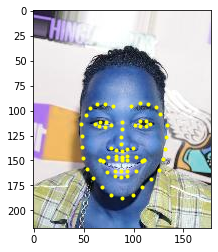

In [ ]:
im = cv2.imread("/content/img_align_celeba/img_align_celeba/" + "190169.jpg")
landmarks = train_data_labels.iloc[44]['landmarks']

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(im)

for landmark in landmarks:
  ax.plot(landmark[0],landmark[1],marker='o',markersize=3,linestyle='-',color='yellow',lw=2)

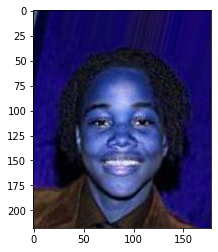

In [ ]:
im = cv2.imread("/content/img_align_celeba/img_align_celeba/" + "200906.jpg")
plt.imshow(im)
plt.show()

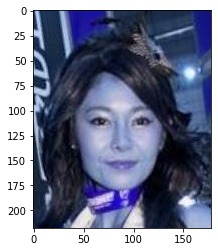

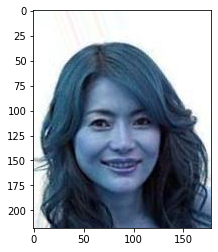

In [490]:
im = cv2.imread("/content/img_align_celeba/img_align_celeba/" + "182959.jpg")
im2 = cv2.imread("/content/img_align_celeba/img_align_celeba/" + "188420.jpg")
plt.figure()
plt.imshow(im)
plt.figure()
plt.imshow(im2)
plt.show()

# Random face similarity to other images

In [ ]:
import altair as alt

In [ ]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
accuracy_df = pd.DataFrame.from_dict(accuracy, orient="index", columns=["accuracy"])
accuracy_df['rank'] = accuracy_df.index
accuracy_df.head()

,accuracy,rank
1,0.081218,1
5,0.101523,5
34,0.203046,34
64,0.253807,64
93,0.289340,93


In [428]:
accuracyVisual = alt.Chart(accuracy_df
  ).mark_line(
  ).encode(
      y = alt.Y('accuracy:Q', title='True identity match',
        scale = alt.Scale(
          domain=[0, 1],
          clamp=True,
          zero=True
        ),
        axis = alt.Axis(format='.0%', labelFontSize=12, titleFontSize=13)
      ),
      x = alt.X('rank:Q', title='K closest images',
                axis = alt.Axis(labelFontSize=12, titleFontSize=13)
                ),
  ).properties(
      title="Accuracy",
      height = 400,
      width = 500
  ).configure_title(fontSize=15)

In [429]:
accuracyVisual

alt.Chart(...)